In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

project_root = str(Path.cwd().parent.parent.parent)

if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary modules
from src.models.custom_functions import (
    SafeIdentityFunction, SafeLog, SafeExp, 
    SafeSin, SafePower, SafeCos
)
from src.training.trainer import Trainer
from src.training.connectivity_trainer import ConnectivityTrainer
from src.utils.plotting import plot_results
from src.utils.data_utils import get_data_loaders, generate_astro_data
from src.models.model_initialization import initialize_model


In [2]:
project_root

'/Users/pablocornejo/Documents/Tesis/SRNetwork'

## First Toy LC

### Trainning on Non-Modified Data

In [3]:
def fn_train(train_loader, val_loader):
    # Define the set of functions
    function_set = {
            "identity": SafeIdentityFunction(),
            "exp": SafeExp(),
            "log": SafeLog(),
            "sin": SafeSin(),
            "cos": SafeCos(),
            "power": SafePower(),
            # Idea: Add "x" function just to know x in the layer
        }

    # Training configuration
    config = {
        'training': {
            'num_epochs': 500,
            'learning_rate': 0.01,
            'reg_strength': 0.0001,
            'decimal_penalty': 0.01,
            'scheduler': 'progressive',  # One of: cosine, cyclic, progressive
            # Connectivity training specific parameters
            'use_connectivity_training': False,  # Set to False for classical training
            'max_architectures': 10,
            'max_patterns_per_layer': 5,
            'num_parallel_trials': 1,
            'print_training_stats': True
        }
    }

    # Model configuration
    input_size = 1
    output_size = 1
    num_layers = 2
    nonlinear_info = [(1, 0), (0, 0), (0, 0)]


    model = initialize_model(
        input_size, 
        output_size, 
        num_layers, 
        function_set, 
        nonlinear_info, 
        min_connections_per_neuron=1, 
        exp_n=1000)

    # Train the model using original trainer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device
    )
    trainer.train()
    trained_model = model
    return trained_model

In [4]:
X, y = generate_astro_data('toy-1')
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

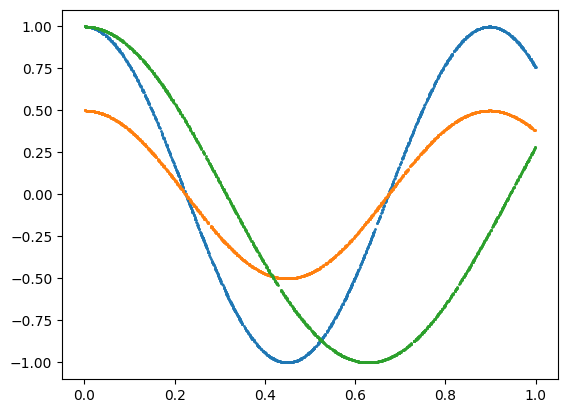

In [5]:
X_1, y_1 = generate_astro_data('toy-1')
X_2, y_2 = generate_astro_data('toy-2')
X_3, y_3 = generate_astro_data('toy-3')

plt.scatter(X_1, y_1, s=1)
plt.scatter(X_2, y_2, s=1)
plt.scatter(X_3, y_3, s=1)
plt.show()


In [6]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/500 - Train Loss: 38.934629 - Val Loss: 32.810107
Epoch 2/500 - Train Loss: 30.487650 - Val Loss: 26.150168
Epoch 3/500 - Train Loss: 23.247707 - Val Loss: 18.788564
Epoch 4/500 - Train Loss: 15.538687 - Val Loss: 11.845726
Epoch 5/500 - Train Loss: 9.787000 - Val Loss: 7.397717
Epoch 6/500 - Train Loss: 6.019175 - Val Loss: 4.446156
Epoch 7/500 - Train Loss: 3.513355 - Val Loss: 2.549324
Epoch 8/500 - Train Loss: 1.962613 - Val Loss: 1.399119
Epoch 9/500 - Train Loss: 1.061473 - Val Loss: 0.750117
Epoch 10/500 - Train Loss: 0.554586 - Val Loss: 0.391167
Epoch 11/500 - Train Loss: 0.288062 - Val Loss: 0.198367
Epoch 12/500 - Train Loss: 0.146536 - Val Loss: 0.102352
Epoch 13/500 - Train Loss: 0.077373 - Val Loss: 0.055141
Epoch 14/500 - Train Loss: 0.043103 - Val Loss: 0.031412
Epoch 15/500 - Train Loss: 0.025624 - Val Loss: 0.018866
Epoch 16/500 - Train Loss: 0.015964 - Val Loss: 0.011707
Epoch 17/500 - Train Loss: 0.010256 - Val Loss: 0.007575
Epoch 18/500 - Train Loss: 0.006

Final equation: y1 = 0.99981*cos(6.99961*x1 - 0.00053)


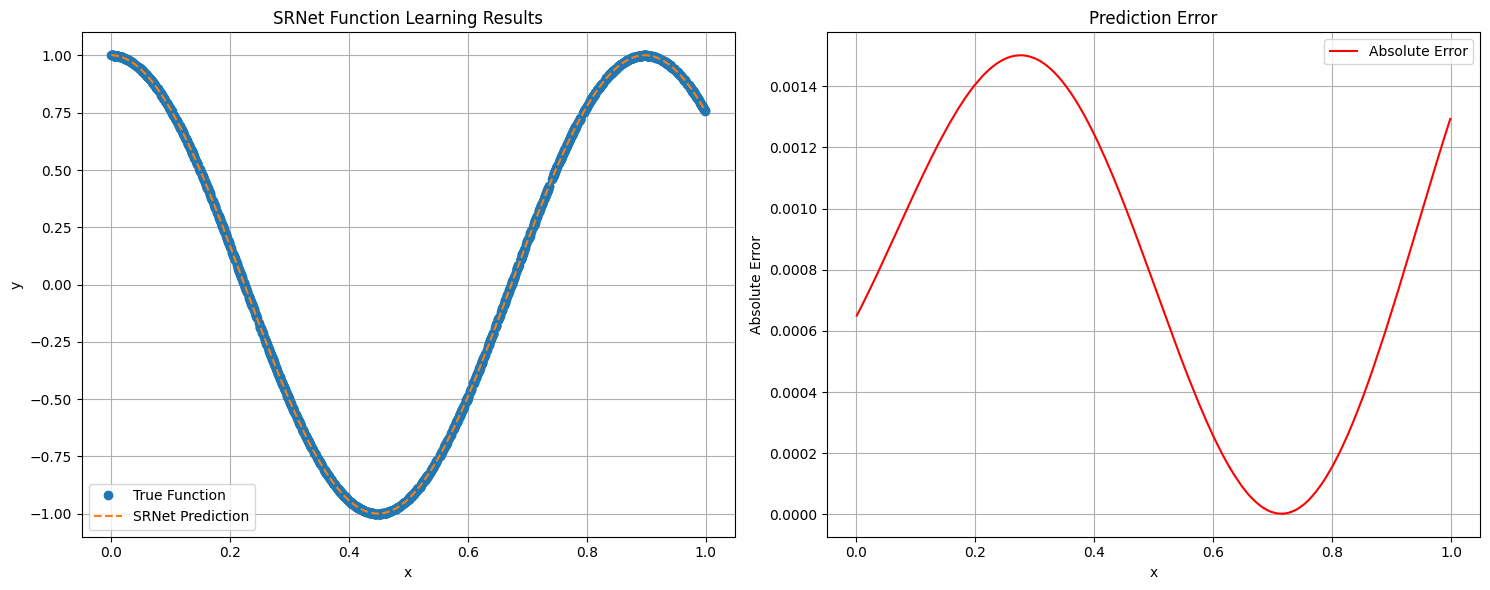

In [7]:
# Get the final equation and evaluate results
device = 'cuda' if torch.cuda.is_available() else 'cpu'


equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

### Trainning on Noisy Data

In [8]:
def add_noise(y, noise_level=0.1):
    """
    Add Gaussian noise to the data.
    
    Args:
        y: Target values
        noise_level: Standard deviation of the noise (default: 0.1)
    
    Returns:
        Noisy target values
    """
    noise = np.random.normal(0, noise_level, y.shape)
    return y + noise

In [9]:
X, y = generate_astro_data('toy-1')
noise_level = 0.5
y_noisy = add_noise(y, noise_level)
y_noisy = y_noisy.to(torch.float32)
train_loader, val_loader = get_data_loaders(X, y_noisy, batch_size=64)


/var/folders/cc/82jm52pj71d81306vc2hnkcm0000gn/T/ipykernel_45788/308883942.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return y + noise


In [10]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/500 - Train Loss: 98.650011 - Val Loss: 78.611846
Epoch 2/500 - Train Loss: 80.200721 - Val Loss: 64.361603
Epoch 3/500 - Train Loss: 65.940627 - Val Loss: 54.467254
Epoch 4/500 - Train Loss: 56.888395 - Val Loss: 48.729670
Epoch 5/500 - Train Loss: 51.870747 - Val Loss: 45.874866
Epoch 6/500 - Train Loss: 49.691970 - Val Loss: 44.907298
Epoch 7/500 - Train Loss: 48.901092 - Val Loss: 44.670894
Epoch 8/500 - Train Loss: 48.640493 - Val Loss: 44.487946
Epoch 9/500 - Train Loss: 48.539038 - Val Loss: 44.423758
Epoch 10/500 - Train Loss: 48.376320 - Val Loss: 44.198217
Epoch 11/500 - Train Loss: 48.146866 - Val Loss: 43.884958
Epoch 12/500 - Train Loss: 47.724170 - Val Loss: 43.409681
Epoch 13/500 - Train Loss: 46.958828 - Val Loss: 42.521023
Epoch 14/500 - Train Loss: 45.698710 - Val Loss: 41.050933
Epoch 15/500 - Train Loss: 43.655059 - Val Loss: 38.823222
Epoch 16/500 - Train Loss: 40.659443 - Val Loss: 36.152238
Epoch 17/500 - Train Loss: 36.943601 - Val Loss: 32.652646
Epoch 

Final equation: y1 = -0.9777*cos(7.12256*x1 - 3.21285)


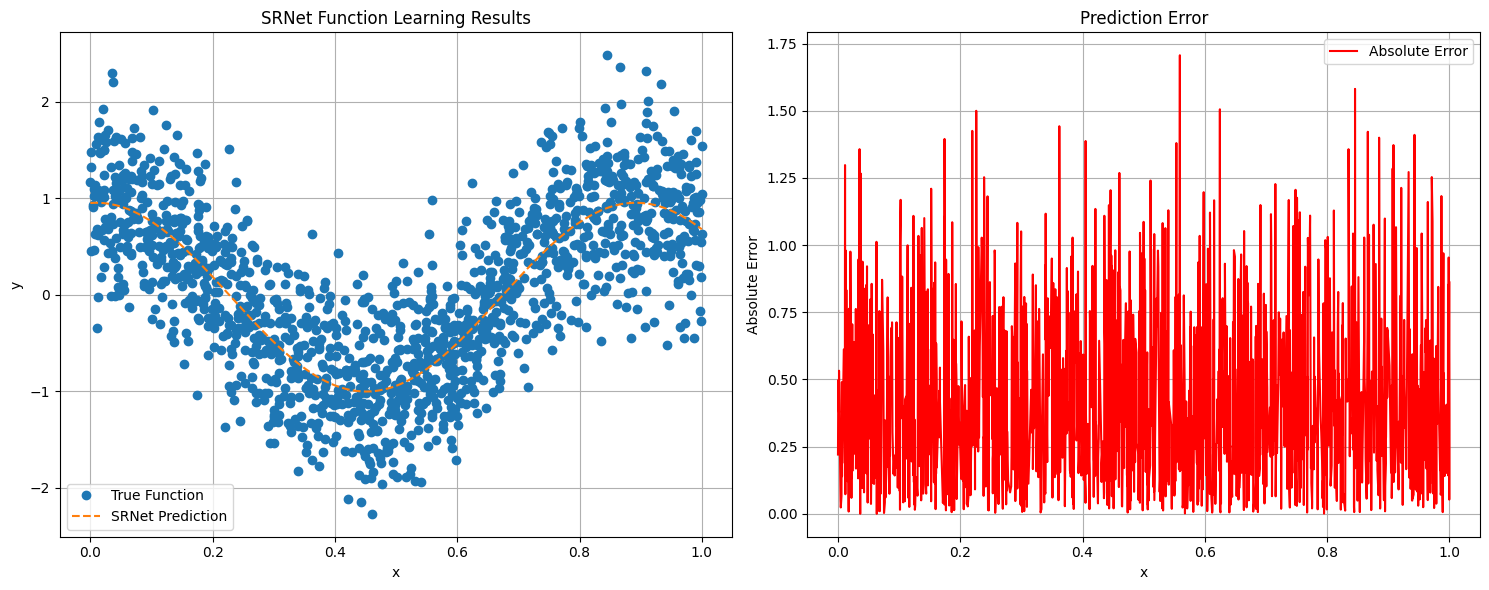

In [11]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y_noisy, predictions)

### Trainning on Sparsity Data

In [12]:
def apply_sparsity(x, y, sparsity_level=0.3):
    """
    Apply sparsity to the data by randomly removing points.
    
    Args:
        x: Input values
        y: Target values
        sparsity_level: Fraction of points to remove (default: 0.3)
    
    Returns:
        Sparse input and target values
    """
    n_points = len(x)
    n_keep = int(n_points * (1 - sparsity_level))
    indices = np.random.choice(n_points, n_keep, replace=False)
    return x[indices], y[indices]

In [13]:
X, y = generate_astro_data('toy-1')
sparsity_level = 0.9
X_sparse, y_sparse = apply_sparsity(X, y, sparsity_level)
#y_sparse = y_sparse.to(torch.float32)
train_loader, val_loader = get_data_loaders(X_sparse, y_sparse, batch_size=64)

 # Initialize model

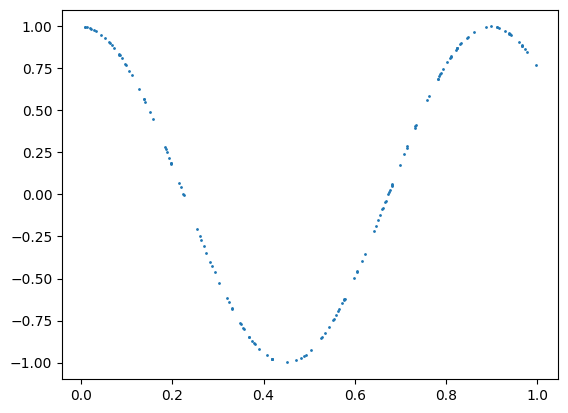

In [14]:
plt.scatter(X_sparse, y_sparse, s=1)
plt.show()

In [15]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/500 - Train Loss: 6.797309 - Val Loss: 5.906178
Epoch 2/500 - Train Loss: 5.831159 - Val Loss: 4.965806
Epoch 3/500 - Train Loss: 5.001418 - Val Loss: 4.176572
Epoch 4/500 - Train Loss: 4.311075 - Val Loss: 3.510859
Epoch 5/500 - Train Loss: 3.655825 - Val Loss: 2.944745
Epoch 6/500 - Train Loss: 3.164358 - Val Loss: 2.453613
Epoch 7/500 - Train Loss: 2.707953 - Val Loss: 2.034844
Epoch 8/500 - Train Loss: 2.328867 - Val Loss: 1.682833
Epoch 9/500 - Train Loss: 1.978262 - Val Loss: 1.394089
Epoch 10/500 - Train Loss: 1.686354 - Val Loss: 1.155863
Epoch 11/500 - Train Loss: 1.437190 - Val Loss: 0.959396
Epoch 12/500 - Train Loss: 1.211681 - Val Loss: 0.797648
Epoch 13/500 - Train Loss: 1.034293 - Val Loss: 0.663372
Epoch 14/500 - Train Loss: 0.876140 - Val Loss: 0.552851
Epoch 15/500 - Train Loss: 0.744957 - Val Loss: 0.462444
Epoch 16/500 - Train Loss: 0.635491 - Val Loss: 0.390157
Epoch 17/500 - Train Loss: 0.547727 - Val Loss: 0.333634
Epoch 18/500 - Train Loss: 0.477485 - Va

Final equation: y1 = 1.0*cos(6.99903*x1 + 0.00049)


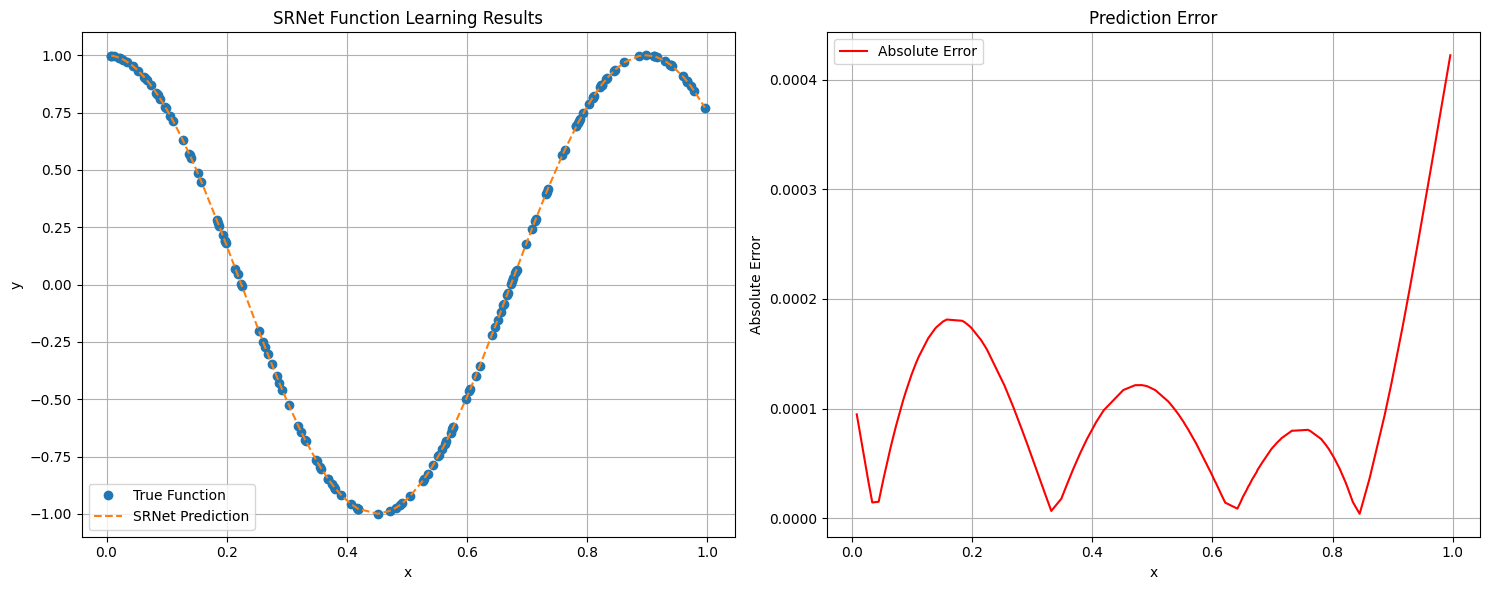

In [16]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X_sparse.to(device))
    predictions = predictions.cpu()
predictions
plot_results(X_sparse, y_sparse, predictions)

### Trainning on Sum-Modified Data

In [17]:
# Define the set of functions
function_set = {
        "identity": SafeIdentityFunction(),
        "exp": SafeExp(),
        "log": SafeLog(),
        "sin": SafeSin(),
        "cos": SafeCos(),
        "power": SafePower(),
        # Idea: Add "x" function just to know x in the layer
    }

# Training configuration
config = {
    'training': {
        'num_epochs': 500,
        'learning_rate': 0.01,
        'reg_strength': 0.0001,
        'decimal_penalty': 0.01,
        'scheduler': 'progressive',  # One of: cosine, cyclic, progressive
        # Connectivity training specific parameters
        'use_connectivity_training': False,  # Set to False for classical training
        'max_architectures': 10,
        'max_patterns_per_layer': 5,
        'num_parallel_trials': 1,
        'print_training_stats': True
    }
}

# Model configuration
input_size = 1
output_size = 1
num_layers = 2
nonlinear_info = [(1, 0), (0, 0), (0, 0)]

In [18]:
X_1, y_1 = generate_astro_data('toy-1')
X_2, y_2 = generate_astro_data('toy-2')
X = torch.cat((X_1, X_2), dim=0)
y = torch.cat((y_1, y_2), dim=0)
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)


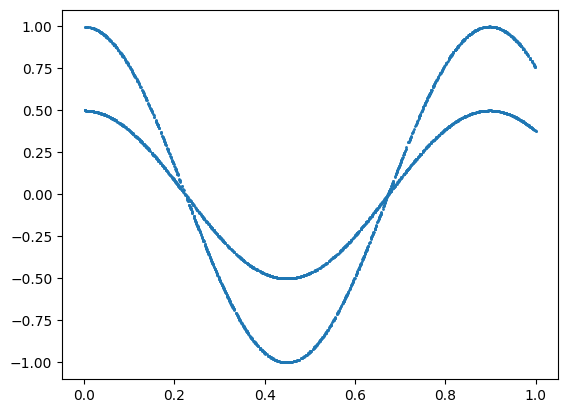

In [19]:
plt.scatter(X, y, s=1)
plt.show()


In [20]:
 # Initialize model
model = initialize_model(
    input_size, 
    output_size, 
    num_layers, 
    function_set, 
    nonlinear_info, 
    min_connections_per_neuron=1, 
    exp_n=1000
)

# Train the model using original trainer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)
trainer.train()
trained_model = model

Epoch 1/500 - Train Loss: 6.605196 - Val Loss: 3.211411
Epoch 2/500 - Train Loss: 2.524135 - Val Loss: 2.281834
Epoch 3/500 - Train Loss: 2.192538 - Val Loss: 2.241525
Epoch 4/500 - Train Loss: 2.168121 - Val Loss: 2.217342
Epoch 5/500 - Train Loss: 2.146409 - Val Loss: 2.162364
Epoch 6/500 - Train Loss: 2.131654 - Val Loss: 2.143224
Epoch 7/500 - Train Loss: 2.116544 - Val Loss: 2.124569
Epoch 8/500 - Train Loss: 2.102679 - Val Loss: 2.108371
Epoch 9/500 - Train Loss: 2.104051 - Val Loss: 2.085199
Epoch 10/500 - Train Loss: 2.089193 - Val Loss: 2.073093
Epoch 11/500 - Train Loss: 2.086356 - Val Loss: 2.066975
Epoch 12/500 - Train Loss: 2.084603 - Val Loss: 2.082452
Epoch 13/500 - Train Loss: 2.085352 - Val Loss: 2.083932
Epoch 14/500 - Train Loss: 2.093485 - Val Loss: 2.069811
Epoch 15/500 - Train Loss: 2.081765 - Val Loss: 2.064987
Epoch 16/500 - Train Loss: 2.079353 - Val Loss: 2.051830
Epoch 17/500 - Train Loss: 2.092968 - Val Loss: 2.050169
Epoch 18/500 - Train Loss: 2.094325 - Va

Final equation: y1 = 0.73758*cos(6.90816*x1 + 0.01889)


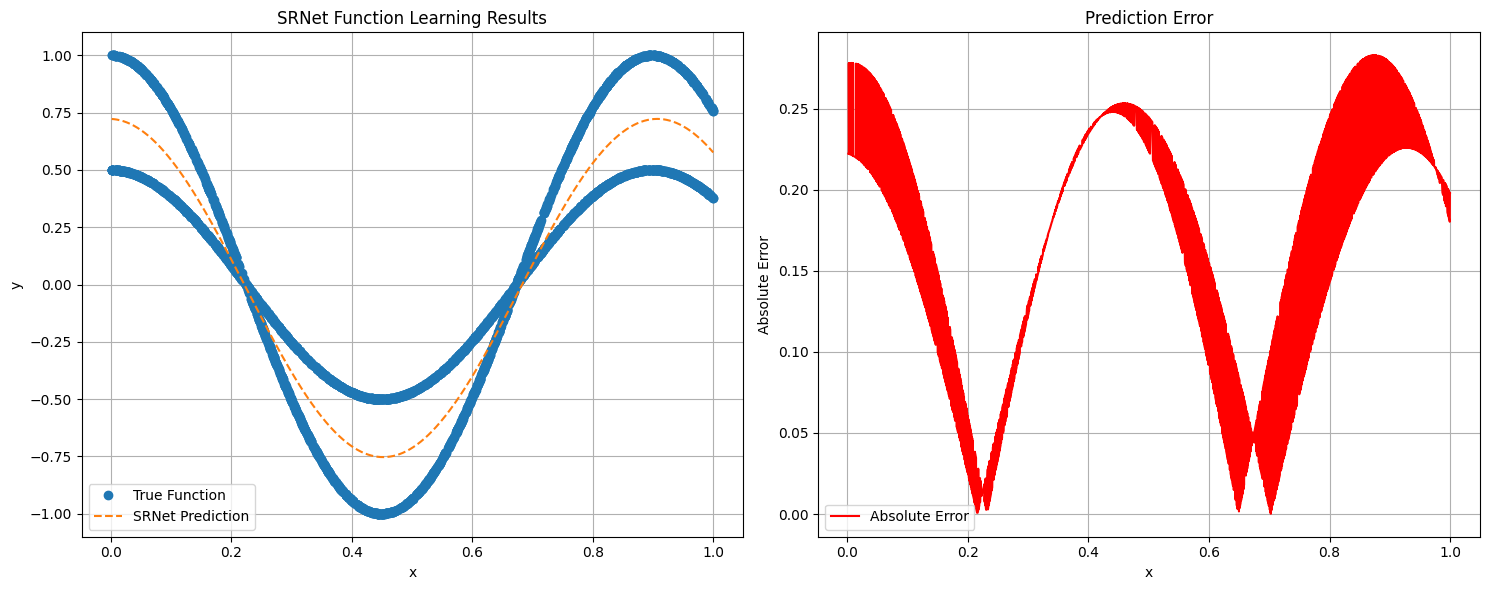

In [21]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

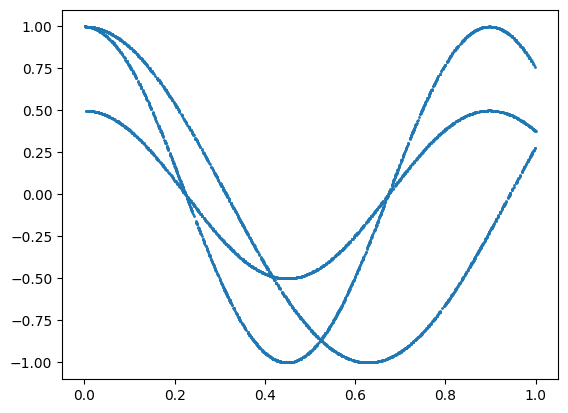

In [22]:
X_1, y_1 = generate_astro_data('toy-1')
X_2, y_2 = generate_astro_data('toy-2')
X_3, y_3 = generate_astro_data('toy-3')
X = torch.cat((X_1, X_2, X_3), dim=0)
y = torch.cat((y_1, y_2, y_3), dim=0)
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

plt.scatter(X, y, s=1)
plt.show()

In [23]:
 # Initialize model
model = initialize_model(
    input_size, 
    output_size, 
    num_layers, 
    function_set, 
    nonlinear_info, 
    min_connections_per_neuron=1, 
    exp_n=1000
)

# Train the model using original trainer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device
)
trainer.train()
trained_model = model

Epoch 1/500 - Train Loss: 13.250340 - Val Loss: 9.148420
Epoch 2/500 - Train Loss: 8.475198 - Val Loss: 8.338779
Epoch 3/500 - Train Loss: 8.318815 - Val Loss: 8.320800
Epoch 4/500 - Train Loss: 8.306231 - Val Loss: 8.317238
Epoch 5/500 - Train Loss: 8.306630 - Val Loss: 8.330115
Epoch 6/500 - Train Loss: 8.317200 - Val Loss: 8.335570
Epoch 7/500 - Train Loss: 8.311006 - Val Loss: 8.415871
Epoch 8/500 - Train Loss: 8.338495 - Val Loss: 8.333061
Epoch 9/500 - Train Loss: 8.308265 - Val Loss: 8.348552
Epoch 10/500 - Train Loss: 8.350497 - Val Loss: 8.327105
Epoch 11/500 - Train Loss: 8.310705 - Val Loss: 8.372928
Epoch 12/500 - Train Loss: 8.351964 - Val Loss: 8.297967
Epoch 13/500 - Train Loss: 8.311822 - Val Loss: 8.319675
Epoch 14/500 - Train Loss: 8.319333 - Val Loss: 8.307111
Epoch 15/500 - Train Loss: 8.326052 - Val Loss: 8.334649
Epoch 16/500 - Train Loss: 8.283249 - Val Loss: 8.307817
Epoch 17/500 - Train Loss: 8.312866 - Val Loss: 8.309243
Epoch 18/500 - Train Loss: 8.308281 - V

Final equation: y1 = 0.69136*cos(6.30975*x1 - 0.06993)


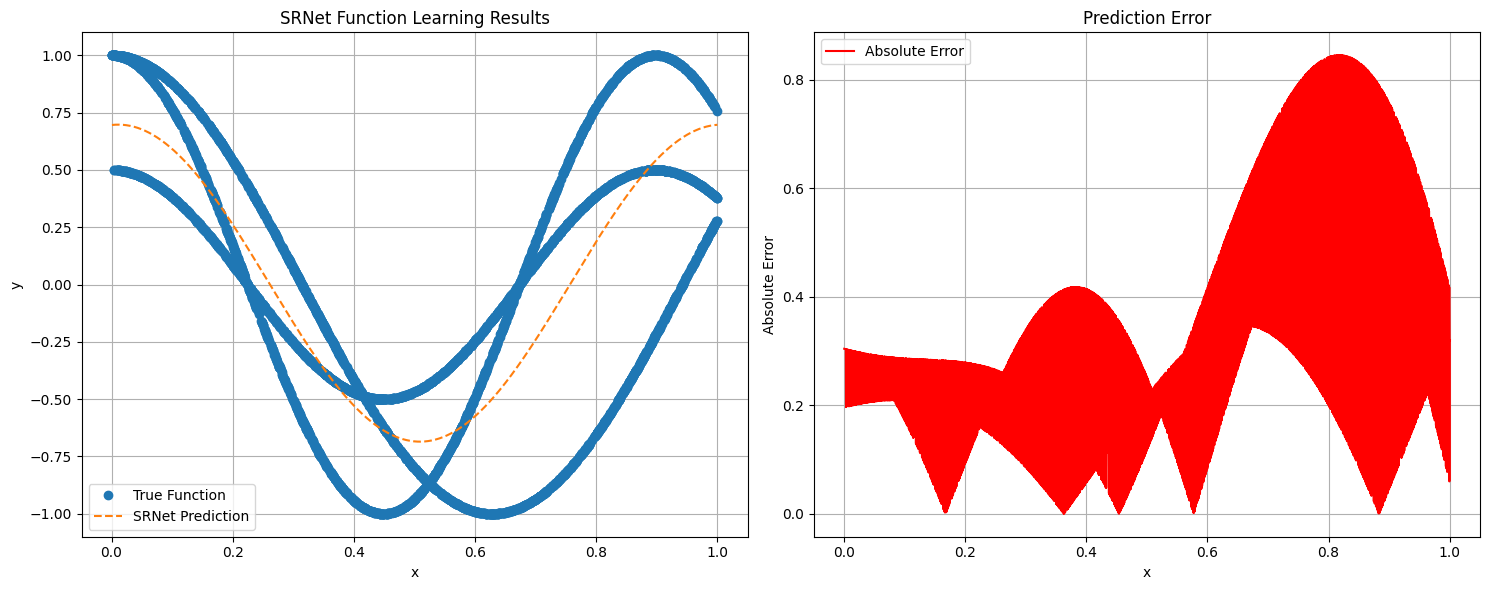

In [24]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

## Socond Toy LC

### Trainning on Non-Modified Data

In [25]:
def fn_train(train_loader, val_loader):
    # Define the set of functions
    function_set = {
            "identity": SafeIdentityFunction(),
            "exp": SafeExp(),
            "log": SafeLog(),
            "sin": SafeSin(),
            "cos": SafeCos(),
            "power": SafePower(),
            # Idea: Add "x" function just to know x in the layer
        }

    # Training configuration
    config = {
        'training': {
            'num_epochs': 1000,
            'learning_rate': 0.01,
            'reg_strength': 0.0001,
            'decimal_penalty': 0.01,
            'scheduler': 'progressive',  # One of: cosine, cyclic, progressive
            # Connectivity training specific parameters
            'use_connectivity_training': False,  # Set to False for classical training
            'max_architectures': 10,
            'max_patterns_per_layer': 5,
            'num_parallel_trials': 1,
            'print_training_stats': True
        }
    }

    # Model configuration
    input_size = 1
    output_size = 1
    num_layers = 2
    nonlinear_info = [(1, 0), (0, 0), (0, 0)]


    model = initialize_model(
        input_size, 
        output_size, 
        num_layers, 
        function_set, 
        nonlinear_info, 
        min_connections_per_neuron=1, 
        exp_n=1001)

    # Train the model using original trainer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device
    )
    trainer.train()
    trained_model = model
    return trained_model

In [26]:
X, y = generate_astro_data('toy-4')
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

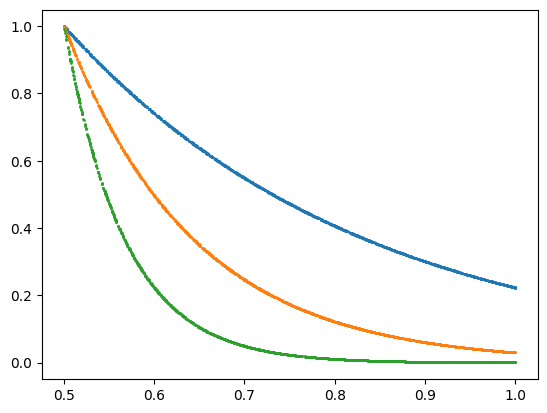

In [27]:
X_1, y_1 = generate_astro_data('toy-4')
X_2, y_2 = generate_astro_data('toy-5')
X_3, y_3 = generate_astro_data('toy-6')

plt.scatter(X_1, y_1, s=1)
plt.scatter(X_2, y_2, s=1)
plt.scatter(X_3, y_3, s=1)
plt.show()


In [28]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 1.499036 - Val Loss: 1.337897
Epoch 2/1000 - Train Loss: 1.269879 - Val Loss: 1.143850
Epoch 3/1000 - Train Loss: 1.057702 - Val Loss: 0.951890
Epoch 4/1000 - Train Loss: 0.843745 - Val Loss: 0.724067
Epoch 5/1000 - Train Loss: 0.633137 - Val Loss: 0.540534
Epoch 6/1000 - Train Loss: 0.455229 - Val Loss: 0.351051
Epoch 7/1000 - Train Loss: 0.297073 - Val Loss: 0.221537
Epoch 8/1000 - Train Loss: 0.183968 - Val Loss: 0.125524
Epoch 9/1000 - Train Loss: 0.105257 - Val Loss: 0.069571
Epoch 10/1000 - Train Loss: 0.061754 - Val Loss: 0.041257
Epoch 11/1000 - Train Loss: 0.038710 - Val Loss: 0.027572
Epoch 12/1000 - Train Loss: 0.028667 - Val Loss: 0.022624
Epoch 13/1000 - Train Loss: 0.025375 - Val Loss: 0.024129
Epoch 14/1000 - Train Loss: 0.024559 - Val Loss: 0.021188
Epoch 15/1000 - Train Loss: 0.022848 - Val Loss: 0.021670
Epoch 16/1000 - Train Loss: 0.023098 - Val Loss: 0.021383
Epoch 17/1000 - Train Loss: 0.023775 - Val Loss: 0.021092
Epoch 18/1000 - Train L

Final equation: y1 = 4.48334*exp(-3.00023*x1)


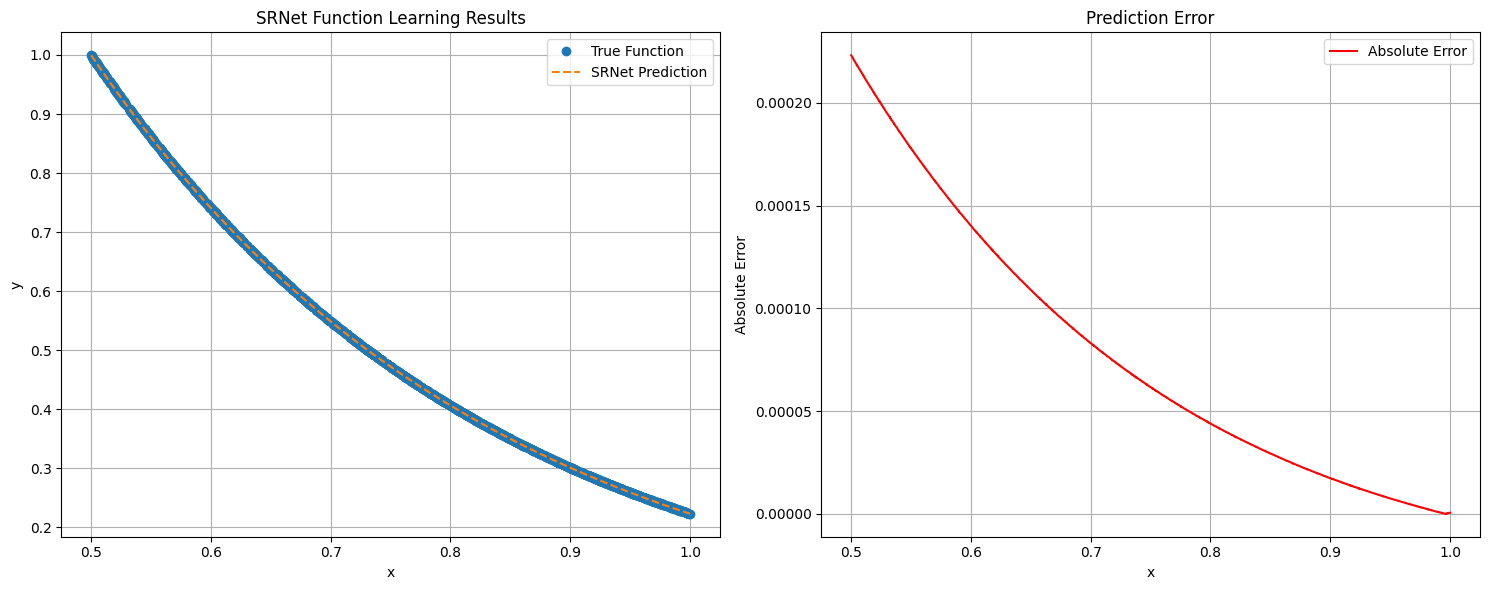

In [29]:
# Get the final equation and evaluate results
device = 'cuda' if torch.cuda.is_available() else 'cpu'


equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

### Trainning on Noisy Data

In [30]:
def add_noise(y, noise_level=0.1):
    """
    Add Gaussian noise to the data.
    
    Args:
        y: Target values
        noise_level: Standard deviation of the noise (default: 0.1)
    
    Returns:
        Noisy target values
    """
    noise = np.random.normal(0, noise_level, y.shape)
    return y + noise

In [31]:
X, y = generate_astro_data('toy-4')
noise_level = 0.5
y_noisy = add_noise(y, noise_level)
y_noisy = y_noisy.to(torch.float32)
train_loader, val_loader = get_data_loaders(X, y_noisy, batch_size=64)


/var/folders/cc/82jm52pj71d81306vc2hnkcm0000gn/T/ipykernel_45788/308883942.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return y + noise


In [32]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 16.995313 - Val Loss: 17.020180
Epoch 2/1000 - Train Loss: 16.907168 - Val Loss: 16.948444
Epoch 3/1000 - Train Loss: 16.795287 - Val Loss: 16.928156
Epoch 4/1000 - Train Loss: 16.732287 - Val Loss: 16.833640
Epoch 5/1000 - Train Loss: 16.631677 - Val Loss: 16.787900
Epoch 6/1000 - Train Loss: 16.570170 - Val Loss: 16.661885
Epoch 7/1000 - Train Loss: 16.507241 - Val Loss: 16.602908
Epoch 8/1000 - Train Loss: 16.455469 - Val Loss: 16.576212
Epoch 9/1000 - Train Loss: 16.382288 - Val Loss: 16.470501
Epoch 10/1000 - Train Loss: 16.320015 - Val Loss: 16.454242
Epoch 11/1000 - Train Loss: 16.334490 - Val Loss: 16.360040
Epoch 12/1000 - Train Loss: 16.217988 - Val Loss: 16.419215
Epoch 13/1000 - Train Loss: 16.165952 - Val Loss: 16.307975
Epoch 14/1000 - Train Loss: 16.093205 - Val Loss: 16.267223
Epoch 15/1000 - Train Loss: 16.082128 - Val Loss: 16.212248
Epoch 16/1000 - Train Loss: 16.147489 - Val Loss: 16.361662
Epoch 17/1000 - Train Loss: 16.080419 - Val Loss:

Final equation: y1 = 3.07462*exp(-1.94246*x1)


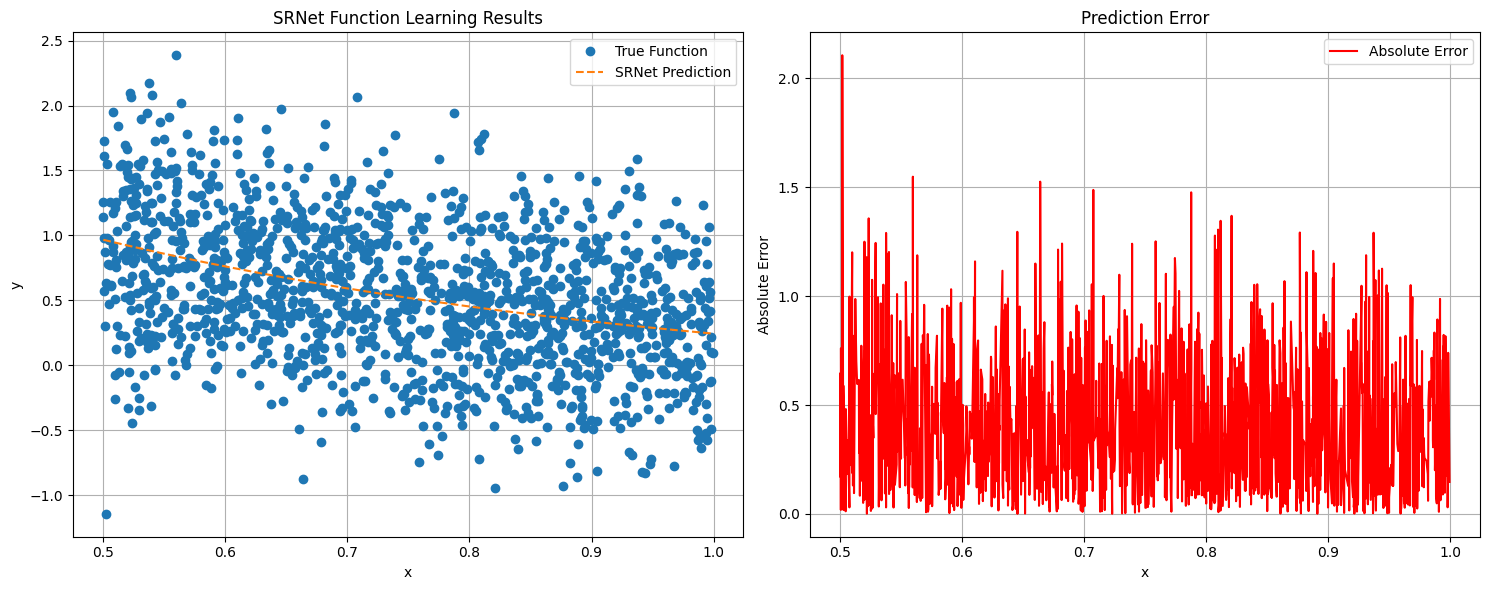

In [33]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y_noisy, predictions)

### Trainning on Sparsity Data

In [34]:
def apply_sparsity(x, y, sparsity_level=0.3):
    """
    Apply sparsity to the data by randomly removing points.
    
    Args:
        x: Input values
        y: Target values
        sparsity_level: Fraction of points to remove (default: 0.3)
    
    Returns:
        Sparse input and target values
    """
    n_points = len(x)
    n_keep = int(n_points * (1 - sparsity_level))
    indices = np.random.choice(n_points, n_keep, replace=False)
    return x[indices], y[indices]

In [35]:
X, y = generate_astro_data('toy-4')
sparsity_level = 0.9
X_sparse, y_sparse = apply_sparsity(X, y, sparsity_level)
#y_sparse = y_sparse.to(torch.float32)
train_loader, val_loader = get_data_loaders(X_sparse, y_sparse, batch_size=64)

 # Initialize model

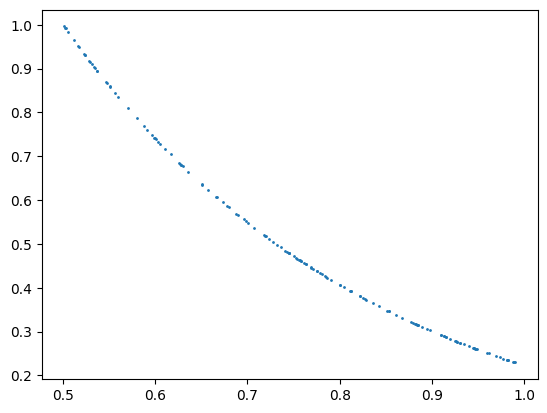

In [36]:
plt.scatter(X_sparse, y_sparse, s=1)
plt.show()

In [37]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 67.930376 - Val Loss: 61.245064
Epoch 2/1000 - Train Loss: 62.579456 - Val Loss: 56.324108
Epoch 3/1000 - Train Loss: 57.649187 - Val Loss: 51.784332
Epoch 4/1000 - Train Loss: 53.081751 - Val Loss: 47.598637
Epoch 5/1000 - Train Loss: 48.789110 - Val Loss: 43.742489
Epoch 6/1000 - Train Loss: 44.890425 - Val Loss: 40.185081
Epoch 7/1000 - Train Loss: 41.331860 - Val Loss: 36.908009
Epoch 8/1000 - Train Loss: 37.997512 - Val Loss: 33.900719
Epoch 9/1000 - Train Loss: 34.946177 - Val Loss: 31.142361
Epoch 10/1000 - Train Loss: 32.189653 - Val Loss: 28.611244
Epoch 11/1000 - Train Loss: 29.655504 - Val Loss: 26.293325
Epoch 12/1000 - Train Loss: 27.349067 - Val Loss: 24.172306
Epoch 13/1000 - Train Loss: 25.173851 - Val Loss: 22.240067
Epoch 14/1000 - Train Loss: 23.238927 - Val Loss: 20.474442
Epoch 15/1000 - Train Loss: 21.515471 - Val Loss: 18.858276
Epoch 16/1000 - Train Loss: 19.831484 - Val Loss: 17.392040
Epoch 17/1000 - Train Loss: 18.340195 - Val Loss:

Final equation: y1 = 3.01404*exp(-1.87884*x1)


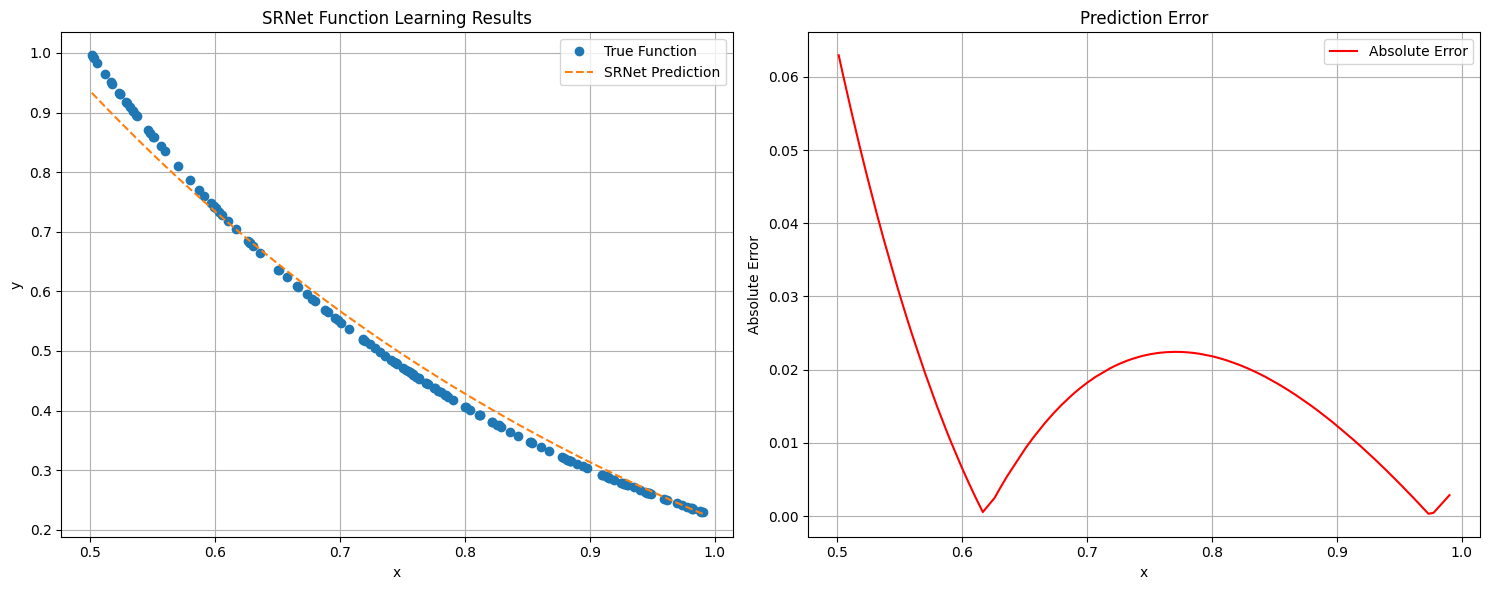

In [38]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X_sparse.to(device))
    predictions = predictions.cpu()
predictions
plot_results(X_sparse, y_sparse, predictions)

### Trainning on Sum-Modified Data

In [39]:
X_1, y_1 = generate_astro_data('toy-4')
X_2, y_2 = generate_astro_data('toy-5')
X = torch.cat((X_1, X_2), dim=0)
y = torch.cat((y_1, y_2), dim=0)
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)


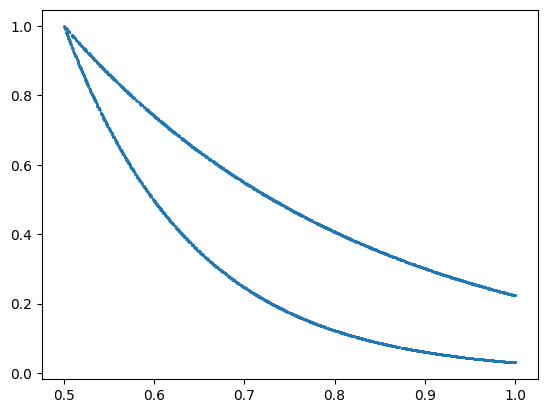

In [40]:
plt.scatter(X, y, s=1)
plt.show()


In [41]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 28.717499 - Val Loss: 4.435669
Epoch 2/1000 - Train Loss: 2.060414 - Val Loss: 1.607561
Epoch 3/1000 - Train Loss: 1.530884 - Val Loss: 1.597570
Epoch 4/1000 - Train Loss: 1.507873 - Val Loss: 1.587434
Epoch 5/1000 - Train Loss: 1.494812 - Val Loss: 1.571483
Epoch 6/1000 - Train Loss: 1.480033 - Val Loss: 1.554400
Epoch 7/1000 - Train Loss: 1.465102 - Val Loss: 1.537842
Epoch 8/1000 - Train Loss: 1.447789 - Val Loss: 1.520815
Epoch 9/1000 - Train Loss: 1.431632 - Val Loss: 1.505024
Epoch 10/1000 - Train Loss: 1.411841 - Val Loss: 1.481288
Epoch 11/1000 - Train Loss: 1.395184 - Val Loss: 1.461993
Epoch 12/1000 - Train Loss: 1.374894 - Val Loss: 1.444709
Epoch 13/1000 - Train Loss: 1.356764 - Val Loss: 1.422207
Epoch 14/1000 - Train Loss: 1.336614 - Val Loss: 1.403100
Epoch 15/1000 - Train Loss: 1.321164 - Val Loss: 1.382492
Epoch 16/1000 - Train Loss: 1.300645 - Val Loss: 1.363554
Epoch 17/1000 - Train Loss: 1.281589 - Val Loss: 1.347527
Epoch 18/1000 - Train 

Final equation: y1 = 9.97899*exp(-4.76014*x1)


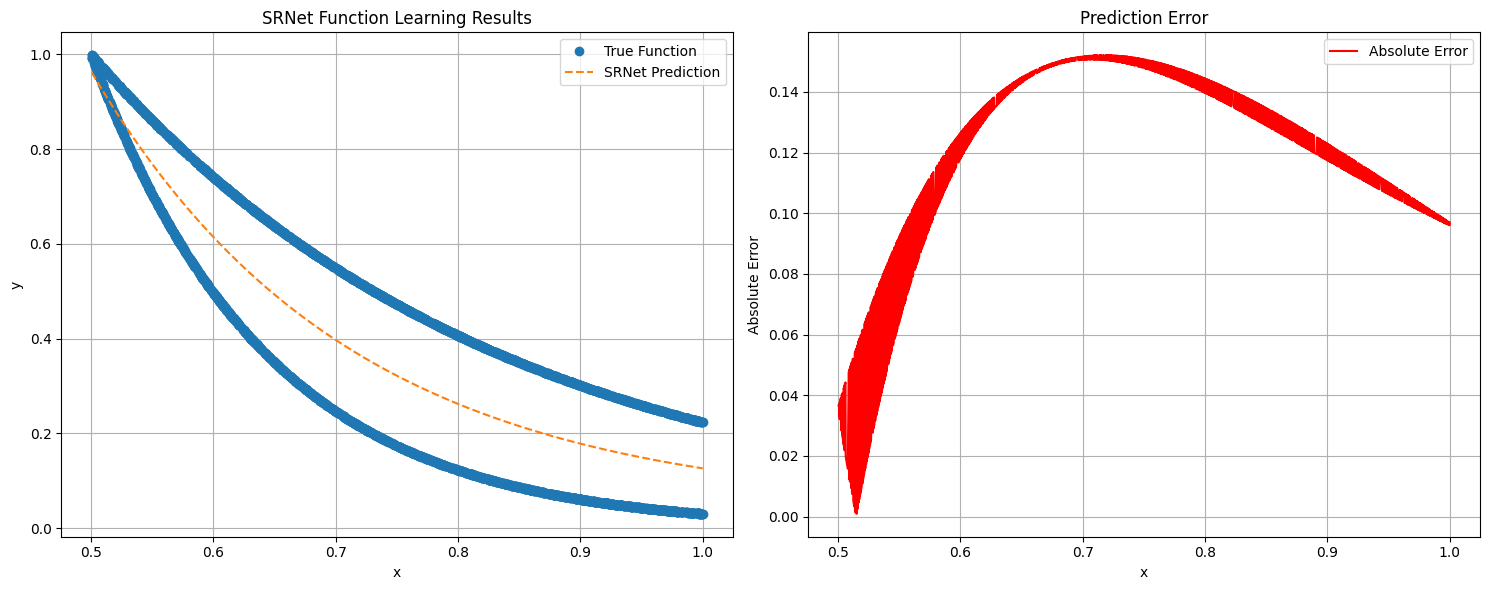

In [42]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)

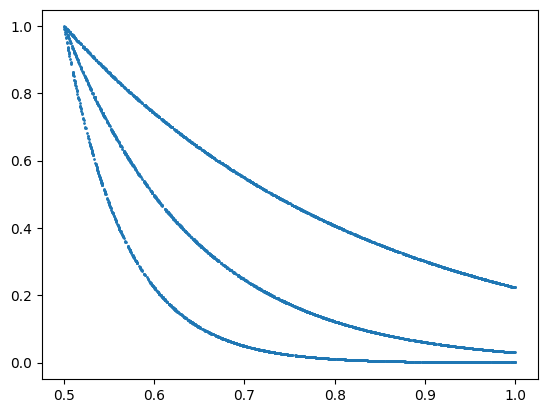

In [43]:
X_1, y_1 = generate_astro_data('toy-4')
X_2, y_2 = generate_astro_data('toy-5')
X_3, y_3 = generate_astro_data('toy-6')
X = torch.cat((X_1, X_2, X_3), dim=0)
y = torch.cat((y_1, y_2, y_3), dim=0)
train_loader, val_loader = get_data_loaders(X, y, batch_size=64)

plt.scatter(X, y, s=1)
plt.show()

In [44]:
trained_model = fn_train(train_loader, val_loader)

Epoch 1/1000 - Train Loss: 4.801920 - Val Loss: 4.135110
Epoch 2/1000 - Train Loss: 4.171470 - Val Loss: 3.763242
Epoch 3/1000 - Train Loss: 3.739669 - Val Loss: 3.293617
Epoch 4/1000 - Train Loss: 3.200730 - Val Loss: 2.753298
Epoch 5/1000 - Train Loss: 2.694695 - Val Loss: 2.349179
Epoch 6/1000 - Train Loss: 2.341266 - Val Loss: 2.115984
Epoch 7/1000 - Train Loss: 2.179545 - Val Loss: 2.025341
Epoch 8/1000 - Train Loss: 2.128031 - Val Loss: 1.998312
Epoch 9/1000 - Train Loss: 2.112673 - Val Loss: 1.990322
Epoch 10/1000 - Train Loss: 2.116371 - Val Loss: 1.986920
Epoch 11/1000 - Train Loss: 2.117702 - Val Loss: 1.983072
Epoch 12/1000 - Train Loss: 2.102256 - Val Loss: 1.998990
Epoch 13/1000 - Train Loss: 2.097506 - Val Loss: 1.977470
Epoch 14/1000 - Train Loss: 2.104218 - Val Loss: 1.974584
Epoch 15/1000 - Train Loss: 2.089386 - Val Loss: 1.975235
Epoch 16/1000 - Train Loss: 2.080422 - Val Loss: 1.995172
Epoch 17/1000 - Train Loss: 2.083846 - Val Loss: 1.971416
Epoch 18/1000 - Train L

Final equation: y1 = 36.8151*exp(-7.50138*x1)


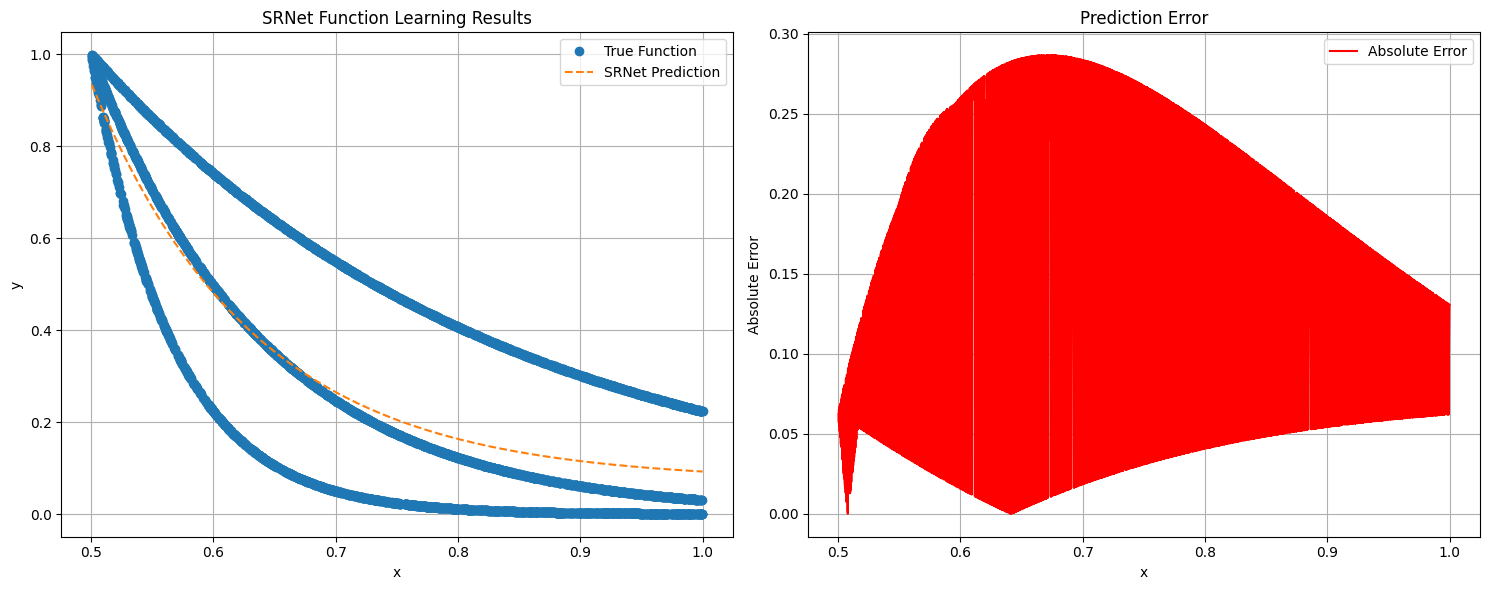

In [45]:
# Get the final equation and evaluate results
equation = trained_model.get_equation()
print(f"Final equation: {equation}")

# Evaluate model
trained_model.eval()
with torch.no_grad():
    predictions = trained_model(X.to(device))
    predictions = predictions.cpu()

plot_results(X, y, predictions)